Project Overview - Pneumonia detection system - CV

The goal is to build a pneumonia detection system, to locate the position of inflammation in an image. Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.In the data, some of these are labeled “Not Normal No Lung Opacity”.This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.Dicom original images: -Medical images are stored in a special format called DICOM files (*.dcm).

They contain a combination of header metadata as well as underlying raw image arrays for pixel data.Details about the data and dataset files are given in below link, https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/
Team

Mentor - Mr. Shirish Patil

Dr. Abhishek Kadam,
Sriram Srinivasan,
Deepak Upadhyay,
Aparna Nammi,
Amit Mahajan.

### Classification Model for Pneumonia Detection-- Mounting the Google Drive

In [1]:
#Mount Google drive if you are using google colab¶
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Declaring the Root Directory

In [2]:
import os
os.chdir('/content/drive/My Drive/CAPSTONE_PROJECT/Kaggle-Data')

path = '.'

In [3]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 

     |████████████████████████████████| 1.9MB 12.9MB/s 


In [4]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 
import tensorflow.keras.layers
import tensorflow.keras.models
import tensorflow.keras.optimizers
import tensorflow.keras.datasets
import tensorflow.keras.utils
import tensorflow.keras.backend
import numpy
import matplotlib.image as mpimg
from PIL import Image

In [5]:
# Root directory of the project
ROOT_DIR = os.path.abspath('/content/drive/My Drive/CAPSTONE_PROJECT/Kaggle-Data')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

In [6]:
import pydicom as dicom
import pandas as pd

In [7]:
os.chdir(ROOT_DIR)
!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!python setup.py -q install

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
zip_safe flag not set; analyzing archive contents...


In [8]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from skimage.transform import resize

In [9]:
train_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_test_images')

In [10]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, str(row['patientId'])+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [47]:
X = []
y = []
z = []
T = []
u = []
V = []
w = []
F = []
img1 = []
img0 = []

In [12]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            y.append(image_annotations[fp]) #Preparing image for image Data Generator CNN         
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            resized_img = resize(image, (128, 128), anti_aliasing=True) #Preparing image for image Data Generator CNN
            X.append(resized_img) #Preparing image for image Data Generator CNN
        for i, a in enumerate(annotations):
                if a['Target'] == 1:
                     resized_img = resize(image, (128, 128), anti_aliasing=True) #Preparing image for image Data Generator CNN
                     T.append(resized_img) #Preparing image for image Data Generator CNN
                     u.append(annotations)
                     img1.append(image_fps)
                if a['Target'] == 0:
                     resized_img = resize(image, (128, 128), anti_aliasing=True) #Preparing image for image Data Generator CNN
                     V.append(resized_img) #Preparing image for image Data Generator CNN
                     w.append(annotations)
                     img0.append(image_fps)
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1  
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [13]:
# training dataset
anns = pd.read_csv(os.path.join(ROOT_DIR, 'stage_2_train_labels.csv'))
anns.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [15]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [16]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [17]:
len(image_fps)

26684

In [ ]:
is_1 =  anns['Target']==1
anns1 = anns[is_1]
anns1.head(6)

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1
15,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1


In [ ]:
is_0 =  anns['Target']==0
anns0 = anns[is_0]
anns0.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0


In [ ]:
anns1.shape

(9555, 6)

In [ ]:
anns0.shape

(20672, 6)

In [ ]:
anns.shape

(30227, 6)

In [ ]:
anns.iloc[4]['patientId']

'00436515-870c-4b36-a041-de91049b9ab4'

In [ ]:
len(image_fps[0])

114

In [ ]:
print (image_fps[0])

/content/drive/My Drive/CAPSTONE_PROJECT/Kaggle-Data/stage_2_train_images/388cc388-c2aa-4bfe-8a63-4565c626d951.dcm


In [ ]:
ds = dicom.read_file(image_fps[0])
df2 = pd.DataFrame(ds.values())
df3 = pd.DataFrame(ds.values())
df3[0] = df3[0].apply(lambda x: dicom.dataelem.DataElement_from_raw(x) if isinstance(x, dicom.dataelem.RawDataElement) else x)
df3['name'] = df3[0].apply(lambda x: x.name)
df3['value'] = df3[0].apply(lambda x: x.value)
df3 = df3[['name', 'value']]

In [ ]:
df2.shape

(35, 1)

In [ ]:
df3.iloc[11][1]

'388cc388-c2aa-4bfe-8a63-4565c626d951'

In [ ]:
print(anns.iloc[11]['patientId'])

009482dc-3db5-48d4-8580-5c89c4f01334


In [ ]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.19752.1517874419.644112
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.19752.1517874419.644112
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
ds[0x0010, 0x0020].value

'388cc388-c2aa-4bfe-8a63-4565c626d951'

In [ ]:
len(image_fps0)

0

In [ ]:
len(image_annotations01)

9555

Split the data into training and validation datasets
Note: We have only used only a portion of the images for demonstration purposes. See comments below.

To use all the images do: image_fps_list = list(image_fps)
Or change the number of images from 100 to a custom number

In [48]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024
######################################################################
# Modify this line to use more or fewer images for training/validation. 
# To use all images, do: image_fps_list = list(image_fps[:3600])
image_fps_list = list(image_fps[:1000]) 
#####################################################################

# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

# prepare the training dataset using the DetectorDataset class
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

900 100


In [ ]:
print (image_fps_list[0])

/content/drive/My Drive/CAPSTONE_PROJECT/Kaggle-Data/stage_2_train_images/43b42736-57c4-447d-9c50-19b92dcde9e3.dcm


Create and prepare the training dataset using the DetectorDataset class.

Let's look at a sample annotation. We see a bounding box with (x, y) of the the top left corner as well as the width and height.

In [ ]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    be5d92d6-f2b3-483c-842c-aff4571ee8a7
 x                                             491
 y                                             340
 width                                         187
 height                                        467
 Target                                          1
 Name: 20949, dtype: object, patientId    be5d92d6-f2b3-483c-842c-aff4571ee8a7
 x                                             113
 y                                             233
 width                                         225
 height                                        523
 Target                                          1
 Name: 20950, dtype: object]

Display a random image with bounding boxes

(1024, 1024, 3)
/content/drive/My Drive/CAPSTONE_PROJECT/Kaggle-Data/stage_2_train_images/345b6880-93d1-4706-872b-04b7cda49f07.dcm
[0]


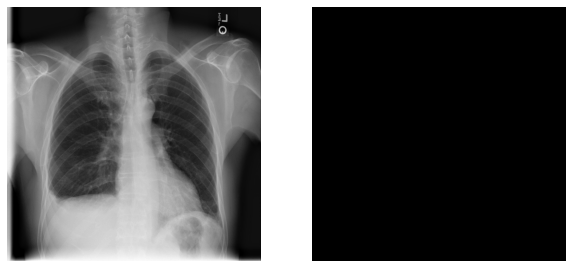

In [ ]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [49]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline
#https://www.kaggle.com/therealcyberlord/pneumonia-detection-using-deep-learning

In [50]:
len(X)
print (X[1])

[[0.00784314 0.01176471 0.01176471 ... 0.01568627 0.01568627 0.01568627]
 [0.00784314 0.01176471 0.01176471 ... 0.01372549 0.01568627 0.01568627]
 [0.01078431 0.01176471 0.01176471 ... 0.01176471 0.01568627 0.01568627]
 ...
 [0.07058824 0.13333333 0.20196078 ... 0.02745098 0.0254902  0.02352941]
 [0.07058824 0.13333333 0.20784314 ... 0.02352941 0.02352941 0.02352941]
 [0.06960784 0.12745098 0.19509804 ... 0.02156863 0.02156863 0.02156863]]


In [51]:
len(y)

1000

In [52]:
print (y[0])

[patientId    dec3b97e-a2e3-45e4-a72d-1d6d9ce016e0
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 24800, dtype: object]


In [24]:
print (y[0][0].patientId)

de7f40b2-741b-4345-881c-856526ec76dc


In [57]:
count = len(y)

In [58]:
z = []

In [59]:
for i in range(count): 
 z.append(y[i][0].Target) 

In [60]:
len(z)

1000

In [61]:
print (z[13])

0


In [62]:
X1 = np.array(X)
y1 = np.array(y)

In [63]:
z1 = np.array(z)

In [64]:
X1.shape

(1000, 128, 128)

In [65]:
X11 = X1.reshape(1000,128,128,1)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X11, z1, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [67]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [68]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

In [90]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.000001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [91]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 128, 128, 256)     2560      
_________________________________________________________________
activation_35 (Activation)   (None, 128, 128, 256)     0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 64, 256)       0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 64, 64, 256)       256       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 64)        147520    
_________________________________________________________________
activation_36 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 64)       

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
64/64 [==============================] - 115s 2s/step - loss: 1.0773 - acc: 0.5172 - val_loss: 0.6931 - val_acc: 0.7312
Epoch 2/20
64/64 [==============================] - 119s 2s/step - loss: 0.7616 - acc: 0.6547 - val_loss: 0.6928 - val_acc: 0.7312
Epoch 3/20
64/64 [==============================] - 116s 2s/step - loss: 0.6921 - acc: 0.6859 - val_loss: 0.6926 - val_acc: 0.7312
Epoch 4/20
64/64 [==============================] - 117s 2s/step - loss: 0.6807 - acc: 0.7188 - val_loss: 0.6926 - val_acc: 0.7312
Epoch 5/20
64/64 [==============================] - 117s 2s/step - loss: 0.7171 - acc: 0.6922 - val_loss: 0.6917 - val_acc: 0.7312
Epoch 6/20
64/64 [==============================] - 116s 2s/step - loss: 0.6710 - acc: 0.7047 - val_loss: 0.6913 - val_acc: 0.7312
Epoch 7/20
64/64 [==============================] - 121s 2s/step - loss: 0.6541 - acc: 0.7125 - val_loss: 0.6912 - val_acc: 0.7312
Epoch 8/20
64/64 [==============================] - 117s 2s/step - loss: 0.6579 - a

In [87]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 7s 957ms/step - loss: 0.5443 - acc: 0.7850


[0.5443217158317566, 0.7850000262260437]

Visualizing our training progress

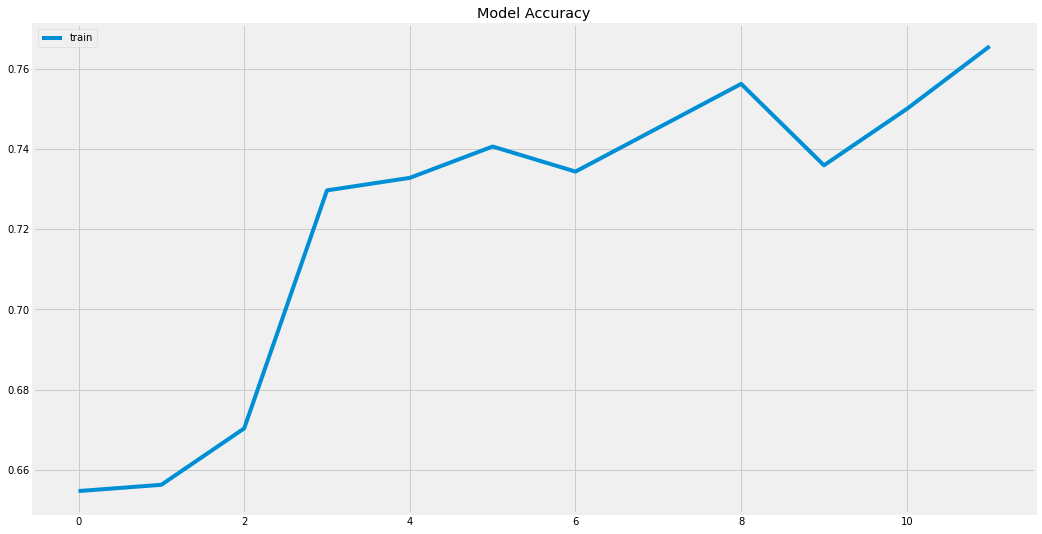

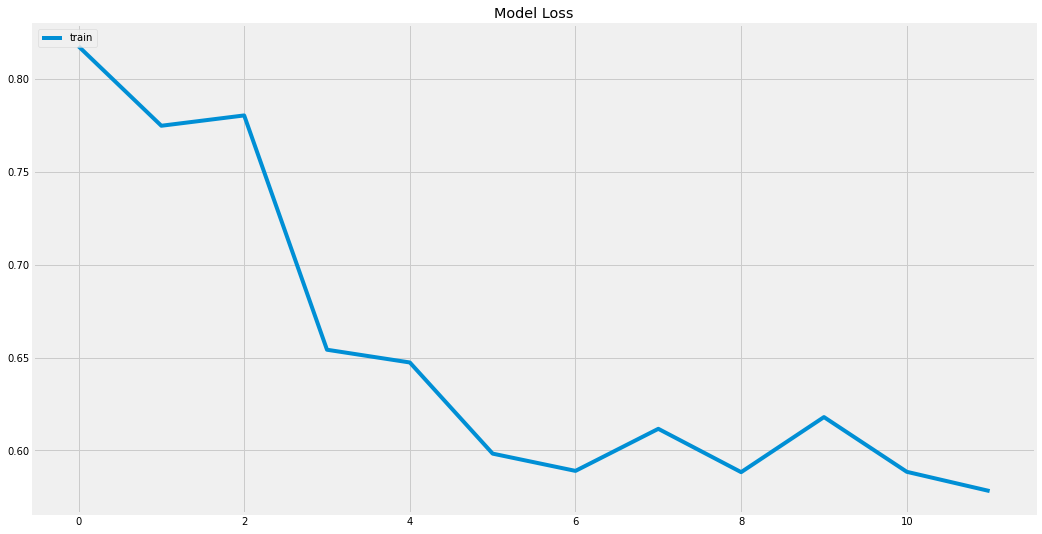

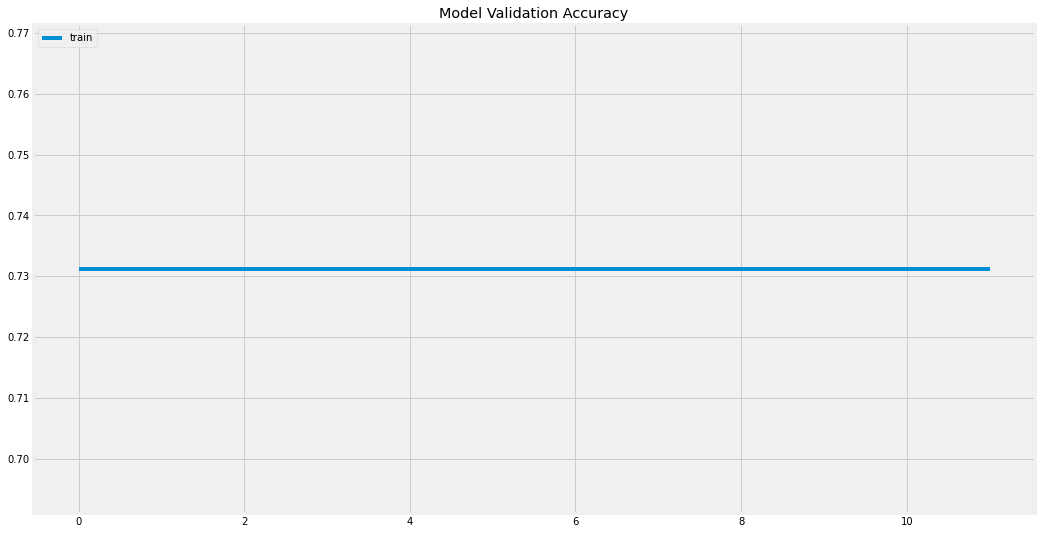

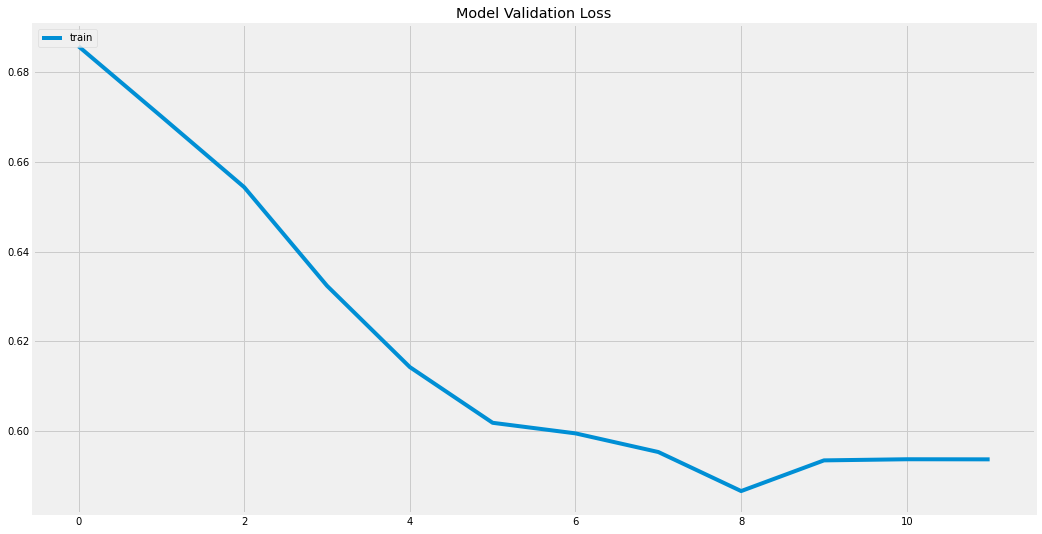

In [88]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

Prepare data for precision vs. recall and ROC

In [ ]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

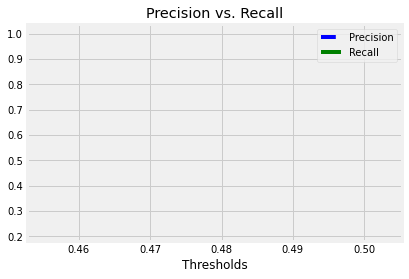

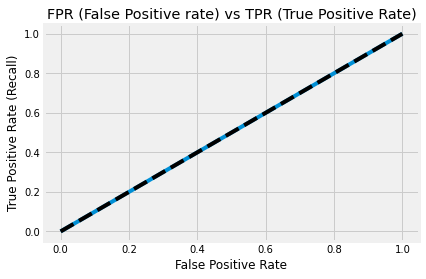

In [ ]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [ ]:
predictions = model.predict(X_test)

Set thresholds for our model, we want the results to be precise while not sacraficing too much recall

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
#from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
preds = model.predict(X_test)

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))
tp, fn, fp, tn = cm.ravel()
auc_score = roc_auc_score(y_test, preds[:,0])

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))
print('AUC Score: {}'.format(auc_score))

print('\nTRAIN METRIC ----------------------')
#print('Train acc: {}'.format(np.round((hist.history['acc'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[18  0]
 [ 2  0]]

TEST METRICS ----------------------
Accuracy: 90.0%
Precision: 90.0%
Recall: 100.0%
F1-score: 94.73684210526316
AUC Score: 0.5

TRAIN METRIC ----------------------
